# 주제: 제주도 도로 교통량과 유의미한 변수
1. EDA
2. 데이터 분석
3. 도로관련 변수 요인분석
4. 요인점수 적용, 미적용 회귀분석 결과 비교
    * 요인점수 적용
    * 요인점수 미적용


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import gc

import os
import glob

# scaler
from sklearn.preprocessing import MinMaxScaler

# 요인분석
from factor_analyzer import FactorAnalyzer

# 회귀분석
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('dataset/train.csv')
info = pd.read_csv('dataset/data_info.csv')

# 1. EDA

### 데이터 정보

* train.csv
    
    * 2022년 8월 이전 데이터만 존재 (단, 날짜가 모두 연속적이지 않음)
    * 4,701,217개의 데이터 (470만여건)
    * target 변수 : 도로의 차량 평균 속도(km/h)
    * 독립변수
        * id : 샘플 별 고유 id
        * 날짜, 시간, 교통 및 도로구간 등 22개변수

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

### 결측치 확인

In [4]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

* 결측치는 없는 것으로 확인됌.

### 데이터 자료형 변형

* 대부분의 값이 int64, float64로 되어 있음.
* 데이터프레임의 용량이 크기 때문에 자료형을 변형해주지 않으면 램 용량을 초과하여 학습을 하지 못할 수도 있음.
* int64를 가진 값 중에서 int32로 변형해도 문제가 될 값은 없음(int32범위는 +-2,147,483,647)
* maximum_speed_limit, vehicle_restricted, weight_restricted, height_restricted, target 도 float32로 바꾸어도 문제가 되지 않음.
* start_latitude, start_longitude, end_latitude, end_longitude 도 float32 변형할 경우 일부 정보가 소실됌.. 따라서 float64 그대로 남겨둠.

In [5]:
# 1차 자료형 변형
to_int32 = ["base_date", "base_hour", "lane_count", "road_rating", "multi_linked", "connect_code", "road_type"]
to_float32 = ["vehicle_restricted", "height_restricted", "maximum_speed_limit", "weight_restricted", "target"]

for i in to_int32:
    train[i] = train[i].astype("int32")
for j in to_float32:
    train[j] = train[j].astype("float32")


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            object 
 3   base_hour              int32  
 4   lane_count             int32  
 5   road_rating            int32  
 6   road_name              object 
 7   multi_linked           int32  
 8   connect_code           int32  
 9   maximum_speed_limit    float32
 10  vehicle_restricted     float32
 11  weight_restricted      float32
 12  height_restricted      float32
 13  road_type              int32  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

### 한 가지 값만 존재하는 컬럼 찾기

In [7]:
only_one_value = []
for i in train.columns[2:]:
    if len(train[i].value_counts()) <2:
        only_one_value.append(i)
len(only_one_value)


2

In [8]:
only_one_value

['vehicle_restricted', 'height_restricted']

In [9]:
np.unique(train["vehicle_restricted"].values)

array([0.], dtype=float32)

* 한 가지 값만 가지는 컬럼값이 2개가 보입니다.
* 위의 컬럼이 존재할 경우 예측하는 데에 방해요소

In [10]:
# 컬럼 제거
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

### 날짜 범위 확인

In [11]:
train.groupby(["base_date"])["target"].size()

base_date
20210901    19722
20210902    18809
20210903    19880
20210904    17998
20210905    17836
            ...  
20220727     9195
20220728     7601
20220729     5138
20220730     1845
20220731     5539
Name: target, Length: 281, dtype: int64

* 21년 9월 1일부터 22년 7월 31일까지의 데이터가 존재합니다
* 우리가 예측해야 하는 항목은 22년 8월 데이터입니다
* 결과를 예측해야 하는 기간(8월)은 train 셋에 존재하지 않습니다.

###  상관관계 분석

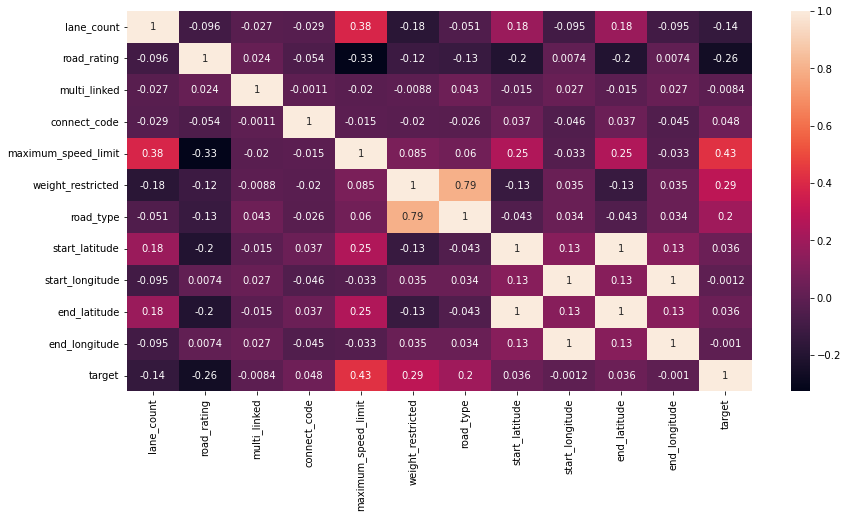

In [12]:
# "base_date"와 "base_hour"는 상관관계를 분석하지 않을 것이기에 임시로 object로 변형
train[["base_date", "base_hour"]] = train[["base_date", "base_hour"]].astype(object)
plt.figure(figsize = (14,7))
sns.heatmap(train.corr(), annot = True)

# object로 변형하였던 "base_hour", "base_date"를 다시 int형으로 변형
train[["base_hour", "base_date"]] = train[["base_hour","base_date"]].astype("int32")

* 예측해야하는 target값과의 상관관계가 높은 것중에 가장 눈에 띄는 컬럼은 maximum_speed_limit입니다. 최고속도 제한이 높을 수록 양의 상관관계가 있다는 것을 알 수 있습니다.
* lane_count(차로 수)는 많을수록 속도가 더 높을 것 같음에도 target과의 음의 상관관계가 나왔습니다.
* weight_restricted(통과 제한 하중)은 target과의 양의 상관관계가 나왔습니다.
* road_rating, road_type은 상관관계가 있으나 데이터를 보아야 원인을 유추할 수 있을 것으로 예상합니다


#### 최고 제한 속도(maximum_speed_limit)


In [13]:
train.maximum_speed_limit.value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='Density'>

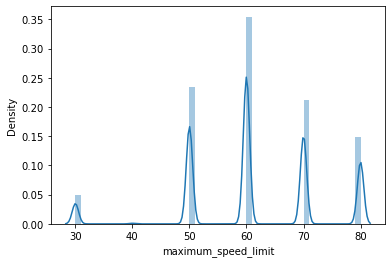

In [14]:
sns.distplot(train.maximum_speed_limit)

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='target'>

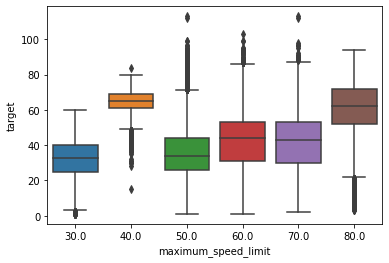

In [15]:
sns.boxplot(x = "maximum_speed_limit", y = "target", data = train)

#### 차로 수(lane_count)

In [16]:
train.lane_count.value_counts()

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64

<AxesSubplot:xlabel='target', ylabel='Count'>

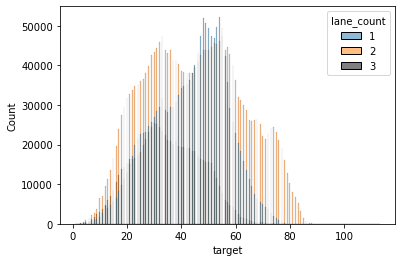

In [17]:
sns.histplot(x = train.target, hue = train.lane_count, palette=["C0", "C1", "k"])

<AxesSubplot:xlabel='lane_count', ylabel='target'>

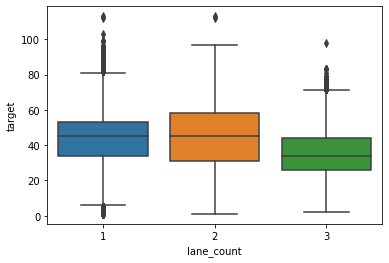

In [18]:
sns.boxplot(x = train.lane_count, y = train.target)

In [19]:
train.groupby("lane_count")["target"].mean()

lane_count
1    43.570560
2    44.915714
3    34.917782
Name: target, dtype: float32

* 차선이 늘어날 수록 속도가 늘어날 것으로 예상했는데 평균속도가 줄어든 모습이 보임.
* 2차선 일 때 가장 빠른 속도를 보였고, 3차선 일 때 가장 느린 속도를 보임.
* 3차선일 때 평균속도가 유의미하게 차이가 나는 것이 확인되므로 학습에 활용할 수 있음.

#### 통과 제한 하중(weight_restricted)

<AxesSubplot:xlabel='weight_restricted', ylabel='target'>

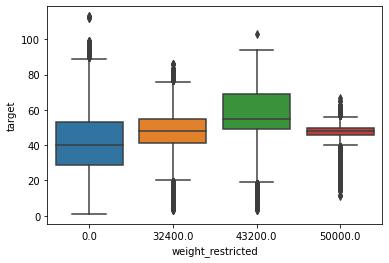

In [20]:
sns.boxplot(x='weight_restricted', y="target", data=train)

In [21]:
train.weight_restricted.value_counts()

0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: weight_restricted, dtype: int64

In [22]:
train.groupby("weight_restricted")["target"].mean()

weight_restricted
0.0        40.955696
32400.0    47.453350
43200.0    57.883888
50000.0    47.088665
Name: target, dtype: float32

<AxesSubplot:xlabel='weight_restricted', ylabel='target'>

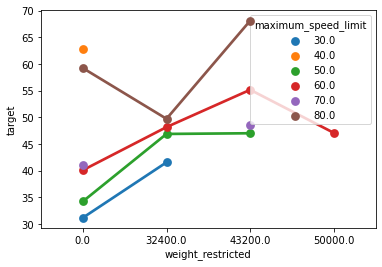

In [23]:
sns.pointplot(data = train, x = "weight_restricted", y = "target", hue= "maximum_speed_limit")

* 제한 하중이 없는 경우 평균속도가 낮습니다.
* 각 제한 하중별 평균값의 차이가 크기 때문에 모델 학습에 활용할 수 있습니다.

### 도로 등급(road_rating)

In [24]:
train.road_rating.value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

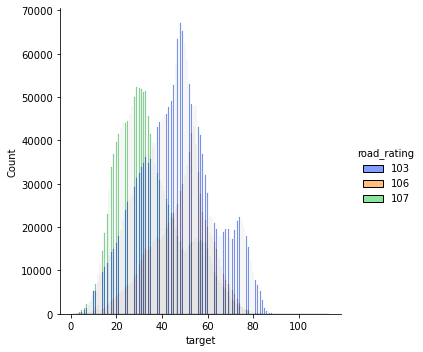

In [25]:
sns.displot(x = train.target, hue = train.road_rating, palette="bright")

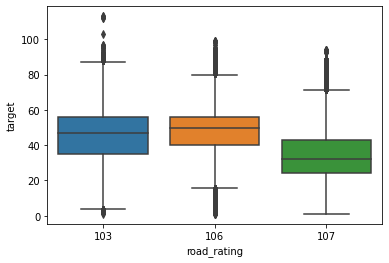

In [26]:
fig = sns.boxplot(x='road_rating', y="target", data=train)

* 평균적으로는 도로등급이 106, 103일 때 높은 속도를 보이며 107은 앞의 두 특성과 비교했을 때 평균 차이가 어느정도 발생합니다.
* 최댓값에서도 도로등급 107이 가장 낮은 속도를 기록하고 있습니다.

### 도로 유형(road_type)

In [27]:
train.road_type.value_counts()

0    3737117
3     964100
Name: road_type, dtype: int64

road_type
0    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: target, dtype: object

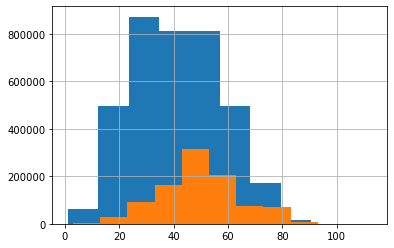

In [28]:
train.groupby("road_type")["target"].hist()

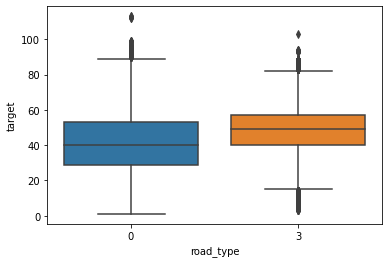

In [29]:
fig = sns.boxplot(x='road_type', y="target", data=train)

In [30]:
print(train.groupby("road_type")["target"].mean())
print(train.groupby("road_type")["target"].max())
print(train.groupby("road_type")["target"].std())

road_type
0    41.160931
3    49.097126
Name: target, dtype: float32
road_type
0    113.0
3    103.0
Name: target, dtype: float32
road_type
0    15.949523
3    14.320773
Name: target, dtype: float64


* 평균의 차이가 어느정도 있으나 큰 차이는 아님.

### 중용구간 여부(multi_linked)
* 중용구간 : 2개 이상의 노선이 도로의 일정 구간을 공동으로 사용하는 구간


In [31]:
train.multi_linked.value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

* 중용구간인 곳은 거의 없음.
* 시각화를 통해 target과의 관계를 확인

multi_linked
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: target, dtype: object

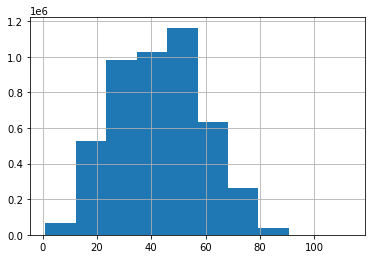

In [32]:
train.groupby("multi_linked")["target"].hist()

* 히스토그램으로 눈에 잡히지 않음.
* 평균값과 표준편차를 확인

In [33]:
print(train.groupby("multi_linked")["target"].mean())
print(train.groupby("multi_linked")["target"].std())

multi_linked
0    42.791370
1    36.642696
Name: target, dtype: float32
multi_linked
0    15.954885
1    13.661950
Name: target, dtype: float64


<AxesSubplot:xlabel='multi_linked', ylabel='target'>

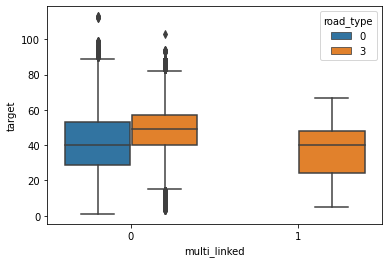

In [34]:
sns.boxplot(x = "multi_linked", y = "target", data = train, hue = "road_type")

* road_type가 0이면서 multi_linked가 1인 값이 존재하지 않습니다.
* multi_linked가 1인 값이 거의 존재하지 않아서 발생하는 문제점입니다.
* 값이 많은 road_type보다, 값이 적은 multi_linked를 제거하는 것이 나을 것으로 예상됩니다.

### 연결로 코드(connect_code)
* “연결로”란 입체교차하는 도로에서 서로 교차하는 도로를 연결하거나 서로 높이 차이가 있는 도로를 연결해 주는 도로를 말함.

In [35]:
train.connect_code.value_counts()

0      4689075
103      12142
Name: connect_code, dtype: int64

connect_code
0      AxesSubplot(0.125,0.125;0.775x0.755)
103    AxesSubplot(0.125,0.125;0.775x0.755)
Name: target, dtype: object

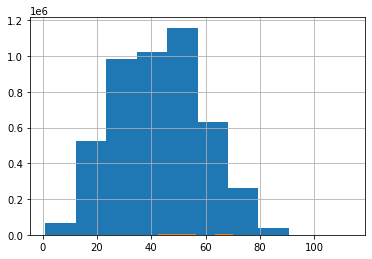

In [36]:
train.groupby(["connect_code"])["target"].hist()

* 중용구간 여부와 마찬가지로 연결로 코드 하나만이 매우 적은 수가 있습니다.
* 역시 평균과 표준편차를 확인해보겠습니다

In [37]:
print(train.groupby("connect_code")["target"].mean())
print(train.groupby("connect_code")["target"].std())

connect_code
0      42.749191
103    57.947044
Name: target, dtype: float32
connect_code
0      15.949711
103     9.075532
Name: target, dtype: float64


* 연결로 코드 103에서 확실히 빠른 평균 속도를 보여주고 있습니다.
* 뿐만 아니라 표준편차도 연결로 코드가 있는 곳이 더 낮은 것을 볼 수 있습니다.

In [38]:
train.groupby(["connect_code"])["road_name"].value_counts()

connect_code  road_name
0             일반국도12호선     1035411
              -             569463
              일반국도16호선      554510
              일반국도95호선      246720
              일반국도11호선      215701
                            ...   
              남조로             6813
              호서중앙로           2819
              호근로              587
103           일반국도12호선       10681
              일반국도95호선        1461
Name: road_name, Length: 63, dtype: int64

In [39]:
temp_connect = train[train["connect_code"] == 103]
temp_connect["road_name"].value_counts()

일반국도12호선    10681
일반국도95호선     1461
Name: road_name, dtype: int64

* 103번 연결로로 확인 되는 곳은 일반국도12호선, 일반국도95호선 2가지 입니다. 12호선과 95호선임에도 연결로가 0으로 된 곳이 있는지 확인이 필요합니다

In [40]:
len(train[train["road_name"] == "일반국도12호선"]), len(train[train["road_name"] == "일반국도95호선"])

(1046092, 248181)

* 너무 데이터가 많은 것 같아 시작 위도와 같은 값들을 바탕으로 일부만 탐색

In [41]:
train[train["road_name"] == "일반국도12호선"]["start_latitude"].value_counts()

33.500330    12113
33.500132    12108
33.499973    12103
33.504059    12095
33.503254    12089
             ...  
33.356098     5080
33.492178     5078
33.254268     4816
33.343079     4653
33.257522     4390
Name: start_latitude, Length: 138, dtype: int64

* 일반국도12호선에서 위도값이 다른 것이 138개나 존재합니다.
* 라벨링이 잘못된 것 같지는 않고 연결로 구간만 라벨링이 된 것으로 보입니다
* 전반적으로 봤을 때 데이터의 수는 매우 적으나 어느정도 유의미한 결과를 보이는 것 같습니다

<AxesSubplot:xlabel='connect_code', ylabel='target'>

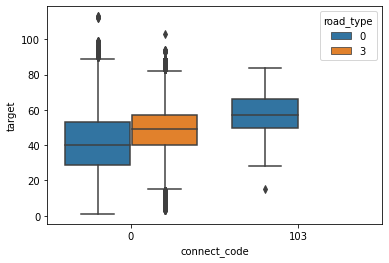

In [42]:
sns.boxplot(x = "connect_code", y= "target", data = train, hue = "road_type")

* connect_code가 103이면서 road_type 가 3인 항목이 존재하지 않음.
* connect_code가 103인 데이터가 너무 소수이기 때문에 발생하는 문제.
* 데이터의 불균형으로 악영향을 줄 수 있으므로 connect_code 컬럼 제거

### 시간(base_hour)

In [43]:
train.groupby("base_hour")["target"].count().sort_values(ascending = True)

base_hour
0     154158
3     155938
4     165284
2     169322
5     181128
1     182353
23    184229
6     189418
7     199061
22    200629
8     201875
21    203585
20    205059
9     205327
10    206316
18    207500
17    208377
16    208420
11    208515
19    209870
12    211833
14    214182
13    214297
15    214541
Name: target, dtype: int64

In [44]:
train.groupby("base_hour")["target"].value_counts(ascending = False)

base_hour  target
0          52.0      4546
           51.0      4545
           50.0      4529
           54.0      4311
           49.0      4149
                     ... 
23         87.0        11
           2.0          9
           88.0         5
           92.0         2
           1.0          1
Name: target, Length: 2100, dtype: int64

## --문제 축소--
* 시간대별 요인별 속도에 영향을 미치는 것이 무엇인지

In [45]:
for i in range(24):
    mean_time = train[train["base_hour"] == i]["target"].mean()
    print("{}시의 평균 속도는 {} km입니다". format(i, mean_time))

0시의 평균 속도는 48.7421989440918 km입니다
1시의 평균 속도는 49.76329803466797 km입니다
2시의 평균 속도는 50.27865982055664 km입니다
3시의 평균 속도는 50.54325485229492 km입니다
4시의 평균 속도는 49.74752426147461 km입니다
5시의 평균 속도는 47.201141357421875 km입니다
6시의 평균 속도는 45.54903030395508 km입니다
7시의 평균 속도는 43.68227005004883 km입니다
8시의 평균 속도는 41.65629196166992 km입니다
9시의 평균 속도는 40.875938415527344 km입니다
10시의 평균 속도는 40.222232818603516 km입니다
11시의 평균 속도는 39.82459259033203 km입니다
12시의 평균 속도는 39.838539123535156 km입니다
13시의 평균 속도는 39.73147201538086 km입니다
14시의 평균 속도는 39.561119079589844 km입니다
15시의 평균 속도는 39.35169982910156 km입니다
16시의 평균 속도는 39.1279296875 km입니다
17시의 평균 속도는 38.47336196899414 km입니다
18시의 평균 속도는 38.24125671386719 km입니다
19시의 평균 속도는 40.10411071777344 km입니다
20시의 평균 속도는 41.113807678222656 km입니다
21시의 평균 속도는 42.173431396484375 km입니다
22시의 평균 속도는 43.98986053466797 km입니다
23시의 평균 속도는 45.8077392578125 km입니다


In [46]:
train.groupby("base_hour")["target"].mean().sort_values(ascending = False)

base_hour
3     50.543255
2     50.278660
1     49.763298
4     49.747524
0     48.742199
5     47.201141
23    45.807739
6     45.549030
22    43.989861
7     43.682270
21    42.173431
8     41.656292
20    41.113808
9     40.875938
10    40.222233
19    40.104111
12    39.838539
11    39.824593
13    39.731472
14    39.561119
15    39.351700
16    39.127930
17    38.473362
18    38.241257
Name: target, dtype: float32

<AxesSubplot:ylabel='target'>

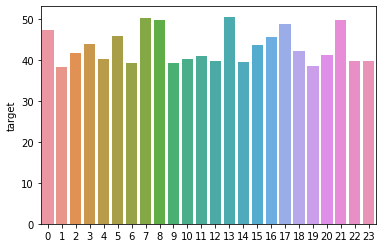

In [47]:
sns.barplot(x = train.base_hour.unique(), y = train.groupby("base_hour")["target"].mean())

<AxesSubplot:xlabel='base_hour', ylabel='target'>

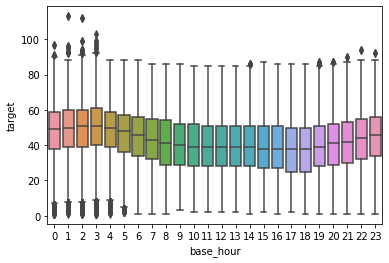

In [48]:
sns.boxplot(x = train.base_hour, y = train.target)

* 밤 11시부터 통행량이 감소하다가 6시 이후로 다시 통행량이 증가하는 양상이 확인됌.
* 통행량이 적은 11시부터 6시 까지는 빠른 속도를 낼 수 있을 것으로 기대됌.
* 위의 시간에 해당하는지에 여부에 따라서 새로운 변수 생성 가능

# 2. 데이터 분석

## 데이터셋 분할

In [49]:
data = train.copy()

In [50]:
# road_name = 지방도 추출

road = data.road_name.unique()
road = [i for i in road if "지방" in i]

data = data.query("road_name in @road")

# 2202년 4월 1일 이전, 이후로 분할
test = data[data.base_date >= 20220401]
train = data[data.base_date < 20220401]

In [51]:
rt = test.shape[0]/train.shape[0]
print(f"train : test = {1-rt} : {rt}")

train : test = 0.661040270128357 : 0.338959729871643


## 전처리

In [52]:
train["month"] = train['base_date'].astype("str").apply(
                               lambda x : x[4:6]).apply(
                               lambda x : int(x) if x[0]!=0 else int(x[-1]))

train["day"] = train['base_date'].astype("str").apply(
                               lambda x : x[-2:]).apply(
                               lambda x : int(x) if x[0]!=0 else int(x[-1]))

test["month"] = test['base_date'].astype("str").apply(
                               lambda x : x[4:6]).apply(
                               lambda x : int(x) if x[0]!=0 else int(x[-1]))

test["day"] = test['base_date'].astype("str").apply(
                               lambda x : x[-2:]).apply(
                               lambda x : int(x) if x[0]!=0 else int(x[-1]))



train["start_turn_restricted"] = train["start_turn_restricted"].map({"없음":0, "있음":1})
test["start_turn_restricted"] = test["start_turn_restricted"].map({"없음":0, "있음":1})

train["end_turn_restricted"] = train["end_turn_restricted"].map({"없음":0, "있음":1})
test["end_turn_restricted"] = test["end_turn_restricted"].map({"없음":0, "있음":1})

In [53]:
day_mean = train.groupby("day_of_week")["target"].mean().reset_index().values
day_mean = {i : j for i, j in day_mean}

train["day_of_week"] = train["day_of_week"].map(day_mean)
test["day_of_week"] = test["day_of_week"].map(day_mean)

In [54]:
road_info = ["lane_count", "maximum_speed_limit", "weight_restricted", "road_type", "start_turn_restricted",
            "end_turn_restricted"] 
day = ["day_of_week", "base_hour", "month", "day"]
col = road_info + day

In [55]:
y_tr = train["target"]
y_te = test["target"]

train = train[col]
test = test[col]

In [56]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train)
train.loc[:, :] = scaler.transform(train)
test.loc[:, :] = scaler.transform(test)

# 3. 도로관련 변수 요인분석

In [57]:
from factor_analyzer import FactorAnalyzer


# 탐색적요인분석
fa = FactorAnalyzer(n_factors=2, rotation='varimax').fit(train[road_info])
# 결과 출력
print('요인적재량 :\n',pd.DataFrame(fa.loadings_, index=road_info))

요인적재량 :
                               0         1
lane_count            -0.095888  1.006479
maximum_speed_limit   -0.084552  0.510503
weight_restricted      0.795582 -0.219084
road_type              0.979173  0.230136
start_turn_restricted  0.029149  0.367815
end_turn_restricted    0.033676  0.258533


- Factor0
    - 통과제한하중, 도로유형에 대한 factor loading 값이 큼
    - "속도에 대한 간접적 요인"라고 명명
- Factor2
    - 차로수, 속도제한, 시작/도착지점 회전제한 유무 대한 factor loading 값이 큼
    - "속도에 대한 간접적 요인"라고 명명 

In [58]:
print('\n공통성 :\n', pd.DataFrame(fa.get_communalities(), index=road_info))


공통성 :
                               0
lane_count             1.022194
maximum_speed_limit    0.267762
weight_restricted      0.680949
road_type              1.011742
start_turn_restricted  0.136138
end_turn_restricted    0.067973


In [59]:
print('\n요인점수 :\n', fa.transform(train[road_info]))


요인점수 :
 [[-0.52681027 -0.72142485]
 [-0.52681027 -0.72142485]
 [-0.99757481  1.66614112]
 ...
 [ 1.35971042  2.20839385]
 [-0.73345151  0.43622822]
 [ 1.35971042  2.20839385]]


# 4. 요인점수 적용, 미적용 회귀분석 결과 비교

In [60]:
train["간접적요인"] = fa.transform(train[road_info])[:, 0]
train["직접적요인"] = fa.transform(train[road_info])[:, 1]

test["간접적요인"] = fa.transform(test[road_info])[:, 0]
test["직접적요인"] = fa.transform(test[road_info])[:, 1]

In [61]:
train_f = train.drop(road_info, axis = 1)
test_f = test.drop(road_info, axis = 1)

In [62]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error
import time

### 4.1. 요인점수 적용

In [135]:
linear = LinearRegression()
ridge = Ridge(random_state = 0)
lasso = Lasso(random_state = 0)
elastic = ElasticNet(random_state = 0)

models = [linear, lasso, ridge, elastic]

benchmark_factor = pd.DataFrame()
for model in models:
    start = time.time()
    model.fit(train_f, y_tr)
    pred = model.predict(test_f)
    tm = time.time() - start
    mae = mean_absolute_error(y_te, pred)
    
    benchmark_factor[str(model.__class__.__name__)] = [mae, tm]
        
    

benchmark_factor.index = (["MAE_factor", "time_factor"])
benchmark_factor.T

,MAE_factor,time_factor
LinearRegression,9.158527,0.058767
Lasso,9.361843,0.027594
Ridge,9.158527,0.026410
ElasticNet,9.392786,0.036640


### 4.2. 요인점수 미적용

In [136]:
linear = LinearRegression()
ridge = Ridge(random_state = 0)
lasso = Lasso(random_state = 0)
elastic = ElasticNet(random_state = 0)

models = [linear, lasso, ridge, elastic]

benchmark = pd.DataFrame()
for model in models:
    start = time.time()
    model.fit(train[col], y_tr)
    pred = model.predict(test[col])
    tm = time.time() - start
    mae = mean_absolute_error(y_te, pred)
    
    benchmark[str(model.__class__.__name__)] = [mae, tm]
        
    

benchmark.index = (["MAE_nofactor", "time_nofactor"])
benchmark.T

,MAE_nofactor,time_nofactor
LinearRegression,7.535561,0.089827
Lasso,9.549749,0.071074
Ridge,7.535572,0.030181
ElasticNet,9.594355,0.060251


In [137]:
final_benchmark = pd.concat([benchmark.T, benchmark_factor.T], axis = 1)

### 4.3. 최종비교

In [138]:
final_benchmark

,MAE_nofactor,time_nofactor,MAE_factor,time_factor
LinearRegression,7.535561,0.089827,9.158527,0.058767
Lasso,9.549749,0.071074,9.361843,0.027594
Ridge,7.535572,0.030181,9.158527,0.026410
ElasticNet,9.594355,0.060251,9.392786,0.036640


In [139]:
# 속도 비교
final_benchmark.time_nofactor.mean() / final_benchmark.time_factor.mean()

1.682153138144751

In [140]:
# Mae 비교
final_benchmark.MAE_factor.mean() / final_benchmark.MAE_nofactor.mean()

1.083484601222273

- MAE
    - 요인변수를 활용해 feature를 줄인 데이터셋을 활용한 경우가 MAE가 평균적으로 1.08배 증가
    - 하지만 Ridge회귀나 Elastic회귀 사용시 오히려 감소
 
- 모델 구현 속도
    - 요인변수를 활용한 경우가 속도가 1.7배 향상